In [1]:
import numpy as np
import scipy as scp
import re
import os
import sys
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import matplotlib.pyplot as plt
import itertools

# adding project folder to lib search path
project = "/".join((os.path.split(os.getcwd())[0], os.path.split(os.getcwd())[1], 'scripts'))
if project not in sys.path:
    sys.path.append(project)

import download

In [2]:
project

'C:\\Users\\Supper\\Desktop\\some codes (do not move it)/hiv_project/scripts'

In [3]:
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
def preparing_data(haplo_seq_dict, days):
    patt = r'_[\d]*_'
    seq_dict = {} 
    seq_name_days_dict = {x:[] for x in days}
    for obj in haplo_seq_dict:
        seq_dict[obj['desc']]=obj['seq']
        res = re.search(patt, obj['desc'])
        if res != None:
            seq_name_days_dict[re.search(patt, obj['desc']).group(0).replace('_','')].append(obj['desc'])
        else:
            pass
    return seq_dict, seq_name_days_dict

def translating_seqs(seq_dict):
    prot_dict = {}
    for key in seq_dict:
        prot_dict[key] = translate_dna(seq_dict[key], '-')
    return prot_dict

In [5]:
codon_table = {'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
              'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
              'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
              'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
              'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
              'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
              'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
              'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
              'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
              'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
              'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
              'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
              'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
              'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
              'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
              'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
              '---': '-',
              }

def translate_dna(seq, gap):
    global codon_table
    prot = []
    res = ''
    for x in seq:
        if x == gap:
            continue
        res += x
        if len(res) == 3:
            if res in codon_table:
                prot.append(codon_table[res])
                res = ''
            else:
                prot.appen('X')
                res = ''
    return ''.join(prot)

In [28]:
haplo_seq_dict, days = download.read_fasta('data/fasta/hivevo_p1_V3.fasta')
seq_dict, seq_name_days_dict = preparing_data(haplo_seq_dict, days)
prot_dict = translating_seqs(seq_dict)

### Making Tree

In [34]:
class Node:
    def __init__(self, parent=None, kids=[], name=None, seq = None, level = None):
        self.parent = parent #node type
        self.kids = kids
        self.name = name
        self.level = level
        self.seq = seq
        
    def __repr__(self):
        return 'Node for haplo: ' + self.name
    
    def find_parent(self, levels_lst, levels_nodes):
        '''
        Finding parent from lower level for node
        '''
        score_max = -float('inf')
        
        low_level = levels_lst[levels_lst.index(self.level)-1]
        low_level_nodes = levels_nodes[low_level]
        
        aligner = Align.PairwiseAligner()
        aligner.match = 1
        aligner.mismatch = -1
        aligner.gap_score = -1
        for node in low_level_nodes:
            score = aligner.score(self.seq, node.seq)
            if score > score_max:
                self.parent = node
                score_max = score
            else:
                continue
        self.parent.kids.append(self)    
    
    def _make_path(self):
        '''
        Making path from final level to reference
        '''
        
        if self.level == 'root':
            return self.name
        else:
            return self.name + ' ' + self.parent._make_path()
    
    def path(self):
        '''
        Making _make_path more useful
        '''
        return self._make_path().split()

class Phylo_tree:
    def __init__(self, root = None):
        self.root = root
        self.levels_nodes = None
        self.levels_lst = None
        self.levels_days = None
    
    def construct_levels(self, days):
        '''
        Fixing construction of our tree
        '''
        self.levels_days = {'level_'+str(i):days[i] for i in range(len(days))}
        self.levels_lst = list(self.levels_days.keys())
        self.levels_nodes = {x:[] for x in self.levels_lst}
        self.levels_nodes['root'] = None
    
    def constructing_tree(self, seq_dict, seq_name_days_dict):
        '''
        Constructing tree using prepared data
        '''
        root_node = Node(name = 'reference', seq = seq_dict['reference'], level = 'root', kids=[])
        self.levels_nodes['root'] = root_node
        for level in self.levels_lst:
            if level == 'level_0':
                for haplotype in seq_name_days_dict[self.levels_days[level]]:
                    node = Node(name=haplotype, seq=seq_dict[haplotype], level=level, parent=root_node)
                    root_node.kids.append(node)
                    self.levels_nodes[level].append(node)
            else:
                for haplotype in seq_name_days_dict[self.levels_days[level]]:
                    node = Node(name=haplotype, seq=seq_dict[haplotype], level=level)
                    node.find_parent(self.levels_lst, self.levels_nodes)
                    self.levels_nodes[level].append(node)
    
    def create_all_path(self):
        '''
        Making all paths from final nodes to reference
        '''
        all_paths = []
        for node in self.levels_nodes[self.levels_lst[-1]]:
            all_paths.append(node.path()[::-1])
        return all_paths

In [35]:
Phylo_tree = Phylo_tree()

In [36]:
Phylo_tree.construct_levels(days)
Phylo_tree.constructing_tree(seq_dict, seq_name_days_dict)
phylo_paths = Phylo_tree.create_all_path()
phylo_paths

[['reference',
  'days_122_frequency_100%',
  'days_562_frequency_16%',
  'days_1084_frequency_48%',
  'days_1254_frequency_39%',
  'days_1282_frequency_16%',
  'days_1393_frequency_24%',
  'days_1861_frequency_100%',
  'days_2303_frequency_68%',
  'days_2578_frequency_13%',
  'days_2639_frequency_15%',
  'days_2922_frequency_1%',
  'days_2996_frequency_1%'],
 ['reference',
  'days_122_frequency_100%',
  'days_562_frequency_16%',
  'days_1084_frequency_48%',
  'days_1254_frequency_39%',
  'days_1282_frequency_16%',
  'days_1393_frequency_24%',
  'days_1861_frequency_100%',
  'days_2303_frequency_68%',
  'days_2578_frequency_13%',
  'days_2639_frequency_15%',
  'days_2922_frequency_1%',
  'days_2996_frequency_1%'],
 ['reference',
  'days_122_frequency_100%',
  'days_562_frequency_16%',
  'days_1084_frequency_48%',
  'days_1254_frequency_39%',
  'days_1282_frequency_16%',
  'days_1393_frequency_24%',
  'days_1861_frequency_100%',
  'days_2303_frequency_68%',
  'days_2578_frequency_13%',


### Classificator

In [11]:
# prepating data

def finding_frequency(string):
    '''
    This function finds frequencies of amino acids. Thus there only amino acid alphabet ('A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X' ) is used. 
    Function return frequency of each amino acid by list: Alanin is first, Argenin - second and so on (see alphabet).
    Parametrs:
        string - what should be analyzed
    '''
    Alphabet = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    result = []
    for x in Alphabet:
            result.append(string.count(x)/len(string))
    return result

def calculating_clf_metric(prot_dict, seq_name_dict, days):
    days_objects = {day:[] for day in days}
    for day in days:
        if day == '0':
            days_objects[day].append(finding_frequency(prot_dict['reference']))
        lst_prot_name = seq_name_dict[day]
        for prot_name in lst_prot_name:
            res = finding_frequency(prot_dict[prot_name])
            days_objects[day].append(res)
    return days_objects

In [17]:
days_objects = calculating_clf_metric(prot_dict, seq_name_days_dict, days)

In [19]:
# Our classificator

Gradboost = load('saved_sklearn_models/Gradboost.joblib')

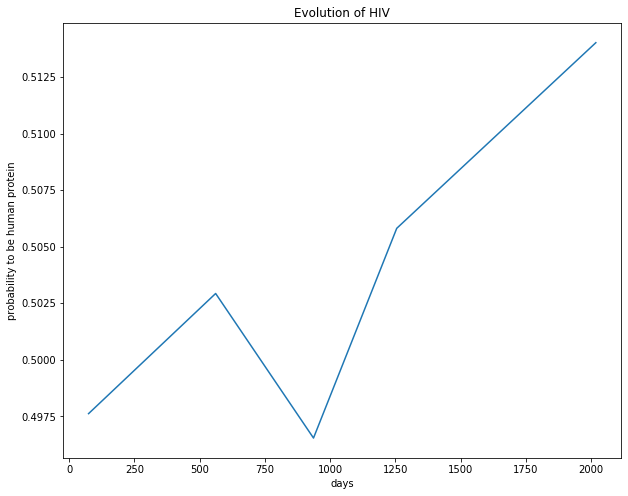

In [30]:
X = list(map(int, list(days_objects.keys())))
Y = []
for day in days:
    obj_lst = days_objects[day]
    res = []
    for pred in Gradboost.predict_proba(obj_lst):
        res.append(pred[0])
    Y.append(max(res))

fig = plt.figure(figsize=(10,8))
plt.xlabel('days')
plt.title('Evolution of HIV')
plt.ylabel('probability to be human protein')
plt.plot(X, Y, label='Gradboost')
plt.show()

### 2-mer

In [37]:
amino_string = 'ARNDCQEGHILKMFPSTWYV'

def making_subseq(k):
    '''Making all subsequences using aminoacids'''
    subseq_iter = itertools.product(amino_string, repeat = k)
    subseq_list = list(subseq_iter)
    del subseq_iter
    for i in range(len(subseq_list)):
        tup = subseq_list[i]
        subseq_list[i] = ''.join(tup)
    return subseq_list

def occurrences_count(string, sub):
    '''
    Counting all ocurrances of substring in string using find() method
    variables:
        string - string where to find
        sub - string to find
    '''
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count

def finding_freq_single_protein(seq):
    
    '''Finding frequnces for subsequences in single protein
    and scaling it with SKlearn StandardScaler()
    return vector_freq'''
    subseq_list = making_subseq(2)
    n = len(seq)
    k = len(subseq_list[0])
    
    vector_freq = []
    
    for x in subseq_list:
        vector_freq.append(float(occurrences_count(seq, x))/n)
    
    vector_freq = np.array(vector_freq)
    vector_freq = vector_freq.reshape((-1, 1))
    scaler = preprocessing.StandardScaler()
    vector_freq_scaled = scaler.fit_transform(vector_freq)
    del vector_freq
    
    return list(vector_freq_scaled)

def clf_metric_2_mer_path(path, prot_dict):
    metric_path = []
    for name in path:
        metric_path.append([])
        prot = prot_dict[name]
        tmp = finding_freq_single_protein(prot)
        for x in tmp:
            metric_path[-1].append(float(x[0]))
        
    return metric_path

In [38]:
# Our classificator

forest_2_mer = load('saved_sklearn_models/forest.joblib')

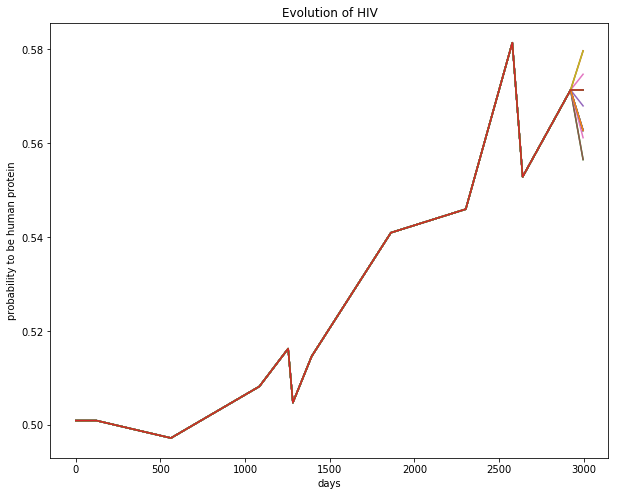

In [39]:
X = list(map(int, days))
X.insert(0, 0)
fig = plt.figure(figsize=(10,8))
for path in phylo_paths:
    met = clf_metric_2_mer_path(path, prot_dict)
    Y = forest_2_mer.predict_proba(met)[:, 1]
    plt.plot(X, Y)
plt.xlabel('days')
plt.title('Evolution of HIV')
plt.ylabel('probability to be human protein')
plt.show()